In [9]:
# !pip install tushare
!pip install mplfinance

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [11]:
import tushare  as ts
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mp
import numpy as np
# https://akshare.akfamily.xyz/tu·torial.html （有时间研究下和tushare类似的akshare）
# https://www.heywhale.com/register_landing

In [ ]:
##machine-learning-for-trading  pythin中最好用的量化交易库

In [12]:
#显示所有列
pd.set_option('display.max_columns', 100)
#显示所有行
pd.set_option('display.max_rows', 100)

In [82]:
#统一数据来源
def get_source():
    pro = ts.pro_api('6797f28ddcb155cb2b9c3b2406a86deb22ddf6f97cf3e461e36b4a85')
    return pro
#股票列表
def get_data():
    df = get_source().stock_basic()
    return df
#获取股票名称
def get_stock_name(df1,df2):
#     name=df.query("ts_code=='{}'".format(df['ts_code']))['name'][0]
    for ts_code in df1['ts_code']:
        for ts_code2 in df2['ts_code']:
            if  ts_code==ts_code2: 
                
                 return df2[df2['ts_code']==ts_code2]['name']
#交易日历
def get_cal():
        df_cal=get_source().trade_cal()
        return df_cal
#
#获取沪股通成分,hs_type:SH,SZ
def stock_kind(kind):
        df_type = get_source().hs_const(hs_type=kind) 
        return  df_type
#上市公司基本信息  交易所代码 ，exchange_name-SSE上交所 SZSE深交所
def company_info(exchange_name,ts_codes):
    df_company =get_source().stock_company(exchange=exchange_name,ts_code=ts_codes, fields='ts_code,chairman,manager,secretary,reg_capital,setup_date,province,city,introduction,website,employees,main_business,business_scope')
    return df_company
#上市公司管理层
def company_managers(ts_code,ann_date,start_date,end_date):
        df_managers= get_source().stk_managers(ts_code=ts_code,ann_date=ann_date,start_date=start_date,end_date=end_date)
        return  df_managers
#管理层持股数
def manager_stocks(ts_code,end_date):
        df_stocks= get_source().stk_rewards(ts_code=ts_code,end_date=end_date)
        return  df_stocks
#IPO新股
def new_stocks(start_date,end_date):
        df_news= get_source().new_share(start_date=start_date, end_date=end_date)
        return  df_news
#股票的换手率问题
#某日换手率前n名的股票 ，或某阶段换手率前n名的股票
def turnover_n(trade_date,n):
    turnover_n=get_source().daily_basic(trade_date=trade_date).sort_values(by='turnover_rate',ascending=False).ts_code.tolist()[:n]
    return turnover_n
#股票的成交额问题。
def amount_n(trade_date,n):
        amount_n=get_source().daily(trade_date=trade_date).sort_values(by='amount',ascending=False).ts_code.tolist()[:n]
        return amount_n
#换手率和成交额的交集
def amount_turnover(trade_date,n):
     return list(set(amount_n(trade_date,n))&set(turnover_n(trade_date,n)))
#备用列表
def get_bakdata(trade_date):
    bak_data=get_source().bak_basic(trade_date=trade_date, fields='trade_date,ts_code,name,industry,pe')
    return bak_data
##获取日线行情
def stock_daily(ts_code,start_date,end_date): 
    if ts_code=='NA':
        df=get_source().daily(trade_date=start_date)
    else:
        df=get_source().daily(ts_code=ts_code, start_date=start_date, end_date=end_date)
    return df
##获取周线行情
def stock_weekly(ts_code,start_date,end_date):
    if ts_code=='NA':
        df=get_source().weekly(trade_date=start_date)
    else:
        df=get_source().weekly(ts_code=ts_code, start_date=start_date, end_date=end_date)
    return df
##获取月线行情

##寻找股票的
# condition = (stock_collection['close']-stock_collection['open'])/stock_collection['open']>0.03
def stock_condition(stock_collection,condition):
    return stock_collection.loc[condition]

#获取历史行情数据

#股票池细化。

#股票列表数据
#RSI指标（）https://xueqiu.com/3733188651/135600477
###第一种表述方式：N日RSI = A / (A + B) × 100
def get_rsi(ts_code,N,start_date,end_date):
    
#     this.ts_code=ts_code
#     this.start_date=start_date
#     this.end_date=end_date
    start_date='20200101'
    df=stock_daily(ts_code,start_date,end_date).query("trade_date<='end_date'")
    df=df.iloc[0:N]
    #df.iloc[0:14].tail(1)['trade_date'].iloc[0]
    ##涨幅之和
    DF_RISE_SUM=df.query("pct_chg>=0")['pct_chg'].sum()
    ##跌幅之和
    DF_DECL_SUM=df.query("pct_chg<0")['pct_chg'].abs().sum()
    RSI_VALUE=(DF_RISE_SUM/(DF_RISE_SUM+DF_DECL_SUM))*100
    arr = np.array(RSI_VALUE)
    arr_rounded = np.round(arr, decimals=4)
    RSI_VALUE=arr_rounded
    return RSI_VALUE
#公式为第二种表述方式：RSI = 100 - 100 / (1 + RS)
def get_rsi_2(ts_code,N,start_date,end_date):
    df=stock_daily(ts_code,start_date,end_date).query("trade_date<='end_date'")
    # 计算收盘价的差分
    df['Diff'] = df['close'].diff()
    # 初始化上涨和下跌幅度列
    df['UpAvg'] = 0
    df['DownAvg'] = 0
    # 计算上涨和下跌幅度的平均值（使用rolling函数，窗口大小为14天）
    # 注意：rolling函数会自动忽略NaN值
    for i in range(len(df)):
        if df['Diff'][i] > 0:
            df.loc[df.index[i], 'UpAvg'] = df['Diff'][i]
        else:
            df.loc[df.index[i], 'DownAvg'] = -df['Diff'][i]
                    
    df['UpAvg']=df['UpAvg'].fillna(0).rolling(window=N).mean()
    df['DownAvg']=df['DownAvg'].fillna(0).rolling(window=N).mean()
    # 计算RS和RSI
    df['RS'] = df['UpAvg']/df['DownAvg']
    df['RSI'] = 100 - (100/(1 + df['RS']))
    
    # 注意：在滚动窗口的初始阶段（前13天），由于数据不足，RSI值可能是NaN
    # 你可以选择填充这些NaN值，或者在使用RSI值时忽略它们
    
    # 示例：填充NaN值为0（这只是一个示例，实际中可能需要根据具体情况来处理）
    # df['RSI'].fillna(0, inplace=True)
    
    # 打印结果
#     return df[['ts_code','trade_date','close','RSI']].iloc[0]
    return df
# 以下获取两个rsI，need a function to be defined
df_test1=stock_daily('002115.SZ','20241130','20250106')
df_test1['RSI']=df_test1.apply(lambda x:get_rsi(x['ts_code'],14,'20200101',x['trade_date']),axis=1)
df2=get_rsi_2('002115.SZ',14 ,'20200101','20250106')
df_test_tmp=df_test1.merge(df2[['ts_code','trade_date','RSI']],on=['trade_date','ts_code'],how='left')
df_test_tmp=df_test_tmp.rename(columns={'RSI_x':'RSI_ACT','RSI_y': 'RSI_AVG'})
df_test1=df_test_tmp
#  以上获取两个rsI，need a function to be defined

##N天前或N天后的日期，PRE,AFT ，即相对强弱指标（Relative Strength Index）
#优化成，这个日期必须是交易日。如：get_N_date('20241225',4,'PRE')
def get_N_date(DATE_SUBMIT,N,DIREC):
    data={'date':[DATE_SUBMIT]}
    df = pd.DataFrame(data) 
    df['date'] = pd.to_datetime(df['date'])
    if DIREC=='PRE':
        df['N_days_ago'] = df['date'] - pd.Timedelta(days=N)
        day_want = df['N_days_ago'].dt.strftime("%Y%m%d").iloc[0]    
    if DIREC=='AFT':
        df['N_days_after'] = df['date'] + pd.Timedelta(days=N)
        day_want=df['N_days_after'].dt.strftime("%Y%m%d").iloc[0]
    return day_want
##获取均线
# def get_avg_vlue(DATE_SUBMIT,N):
#     五日均线
#     十日均线

    
    
    

In [109]:
# 

In [110]:
# 

In [111]:
# df_test_tmp.head(50)

In [112]:
# get_rsi_2('002115.SZ',14,'20200101','20250103`dd

In [113]:
# 


In [114]:
# df_test1

In [115]:
# df_test1.head(30).to_excel("./Data/stock_rsi_test.xlsx")
# df_test_tmp

In [116]:
# df_test1

In [117]:
# df.query("pct_chg>=0")['pct_chg'].sum()

In [118]:
# -df.query("pct_chg<0")['pct_chg'].sum()

In [119]:
# print(1.7391999999999999/(56.3183+1.7391999999999999)*100)

In [121]:
# df.iloc[0:14]
# df.loc[0:2]

In [122]:
# len(df.query("trade_date<='20250103'"))

In [123]:
# df.iloc[0:13]

In [124]:
# df.head(10)

In [125]:
# df_test1['trade_date_tr'] = pd.to_datetime(df_test1['trade_date'])

In [126]:
# get_rsi('002115.SZ','20241101','20241225')

In [127]:
# df_test1['RSI']=df_test1.apply(lambda x:get_rsi(x['ts_code'],14,'20200101',x['trade_date']),axis=1)

# get_rsi(ts_code,N,start_date,end_date)

In [128]:
# df_test1

In [84]:
# 

6.246

In [129]:
# df_test1.head(20)

In [130]:
# df_test1['trade_date'].max()

In [131]:
# get_rsi('600000.SH','20241201','20241216')

In [3]:
##股票财务数据

fields='ts_code,ann_date,f_ann_date,end_date,report_type,comp_type,basic_eps,diluted_eps,total_revenue'
df_stocks_finance=get_source().income(ts_code='600000.SH', start_date='20230101', end_date='20240802')
##资产负债表数据
fields='ts_code,ann_date,f_ann_date,end_date,report_type,comp_type,cap_rese'
df_stocks_balance_sheet=get_source().balancesheet(ts_code='600000.SH', start_date='20230101', end_date='20240802')
##现金流量表
df_cashflow =get_source().cashflow(ts_code='600000.SH', start_date='20180101', end_date='20240802')

##业绩快报
df_express=get_source().express(ts_code='600000.SH', start_date='20180101', end_date='20240802', fields='ts_code,ann_date,end_date,revenue,operate_profit,total_profit,n_income,total_assets')
# df_express_vip=get_source().express_vip(period='20221231',fields='ts_code,ann_date,end_date,revenue,operate_profit,total_profit,n_income,total_assets')

In [4]:
# df_stocks_finance

In [132]:
#基本状况、财务指标状况、行业市场声誉和市场潜力、公司声誉和公司潜力，公司人员状况、领导能力。
df_stocks=get_data()
# 1、需求超过三年的上市公司股票列表
df_stocks_age_gt3=df_stocks.query('list_date <"20210101"')

# df_stocks.query("ts_code.str.contains('002329.SZ|688271.SH|002514.SZ|688041.SH|688016.SH|002197.SZ')",engine="python")
#20221207
# 比如“ROE连续5年大于20%”“近两年营收增长率大于10%”“近两年净利润增长率大于10%”“上市时间大于3年”等
df_stocks_age_gt3['industry']=df_stocks_age_gt3['industry'].apply(str)
##选定超过三年的行业股票
df_stocks_age_gt3_base=df_stocks_age_gt3.query("industry.str.contains('人工智能|通信|信息|医|互联网|新能源|材料|高端|消费|软件|电力|汽车配件|通信设备|旅游景点')",engine="python")[['ts_code','name','industry']]
#如何获取ROE

C:\Users\whglo\AppData\Local\Temp\ipykernel_38328\1484393766.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stocks_age_gt3['industry']=df_stocks_age_gt3['industry'].apply(str)


# 超过三年 的医药、互联网、新能源、材料、高端、消费类的股票

In [11]:
# df_stocks_age_gt3_base.head(50)

In [32]:
pd.DataFrame(df_stocks_age_gt3.industry.unique()).to_excel("./Data/industry_stock.xlsx")

In [6]:
# df_stocks_age_gt3.industry.to_excel("./Data/industry_stock.xlsx")

In [141]:
import time
from time import mktime
from dateutil.relativedelta import relativedelta
from datetime import datetime,timedelta

#根据这些股票，加上日期，ROE,换手率、成交额等信息。
# df_stocks_age_gt3_base.head(1000)
#日行情信息 及晒选。
# trdate=(datetime.today().date() - timedelta(days=0)).strftime('%Y%m%d')
trdate='20250106'
#交易日期所在周
# trdate_week=

stock_collection=stock_daily('NA',trdate,'')
condition = (stock_collection['close']-stock_collection['pre_close'])/stock_collection['pre_close']>0.05
df_selected=stock_condition(stock_collection,condition)
#股票信息
colname=['ts_code','name','industry','trade_date','open','high','low','close','pre_close','change','pct_chg','amount']
df_selected_tmp1=pd.merge(df_selected,df_stocks_age_gt3_base,on=["ts_code"],how='inner')[colname]
#加上换手率 、市赢率、市盈率TTM、市净率
df_index_daily = get_source().index_dailybasic(trade_date=trdate
#                                                ,fields='ts_code,trade_date,turnover_rate,pe'
                                              )
colname.extend(['turnover_rate','turnover_rate_f','pe','pe_ttm','pb'])  

df_selected_tmp2=pd.merge(df_selected_tmp1,df_index_daily,on=["ts_code","trade_date"],how='left')[colname]
#加上成交额
#加上 ROE


In [142]:
df_selected_tmp2.industry.unique()

array(['互联网', '软件服务', '医药商业', '汽车配件', '通信设备', '医疗保健'], dtype=object)

In [143]:
df_selected_tmp2.query("close<=10")

,ts_code,name,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,amount,turnover_rate,turnover_rate_f,pe,pe_ttm,pb
0,002127.SZ,南极电商,互联网,20250106,4.38,4.93,4.34,4.75,4.50,0.25,5.5556,744044.983,NaN,NaN,NaN,NaN,NaN
2,002390.SZ,信邦制药,医药商业,20250106,4.25,4.56,4.18,4.55,4.25,0.30,7.0588,401771.728,NaN,NaN,NaN,NaN,NaN
9,600829.SH,人民同泰,医药商业,20250106,7.44,7.99,7.38,7.85,7.35,0.50,6.8027,197257.725,NaN,NaN,NaN,NaN,NaN


In [138]:
df_test1=stock_daily('002127.SZ','20241130','20250106')
df_test1['RSI']=df_test1.apply(lambda x:get_rsi(x['ts_code'],14,'20200101',x['trade_date']),axis=1)
df2=get_rsi_2('002127.SZ.SZ',14 ,'20200101','20250106')
df_test_tmp=df_test1.merge(df2[['ts_code','trade_date','RSI']],on=['trade_date','ts_code'],how='left')
df_test_tmp=df_test_tmp.rename(columns={'RSI_x':'RSI_ACT','RSI_y': 'RSI_AVG'})
df_test1=df_test_tmp


In [139]:
df_test1.head(30)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,RSI_ACT,RSI_AVG
0,002127.SZ,20250106,4.38,4.93,4.34,4.75,4.50,0.25,5.5556,1597510.06,744044.983,41.0499,NaN
1,002127.SZ,20250103,4.72,4.73,4.42,4.50,4.83,-0.33,-6.8323,1888473.32,861867.534,41.7301,NaN
2,002127.SZ,20250102,4.36,4.84,4.36,4.83,4.40,0.43,9.7727,2870791.18,1365419.953,44.5743,NaN
3,002127.SZ,20241231,4.39,4.49,4.28,4.40,4.37,0.03,0.6865,1109752.00,487461.390,41.2697,NaN
4,002127.SZ,20241230,4.36,4.40,4.22,4.37,4.36,0.01,0.2294,681817.60,294682.821,39.3713,NaN
5,002127.SZ,20241227,4.28,4.45,4.22,4.36,4.31,0.05,1.1601,800608.60,348118.670,48.4707,NaN
6,002127.SZ,20241226,4.22,4.44,4.21,4.31,4.23,0.08,1.8913,959181.26,418253.212,44.9041,NaN
7,002127.SZ,20241225,4.45,4.45,4.15,4.23,4.46,-0.23,-5.1570,1268231.45,537947.072,41.9088,NaN
8,002127.SZ,20241224,4.49,4.56,4.35,4.46,4.48,-0.02,-0.4464,1012079.33,450061.743,48.5985,NaN
9,002127.SZ,20241223,4.90,4.95,4.46,4.48,4.96,-0.48,-9.6774,1975146.82,904603.040,47.5792,NaN


In [144]:
# df_selected_tmp2.query("industry in ('医疗保健','汽车配件','新型电力') ")
# df_selected_tmp2.query("industry in ('新型电力') ")
# df_selected_tmp2.query("industry in ('旅游景点') ")
df_stocks_age_gt3_base.query("industry in ('通信设备') ")

,ts_code,name,industry
42,000063.SZ,中兴通讯,通信设备
47,000070.SZ,ST特信,通信设备
126,000547.SZ,航天发展,通信设备
138,000561.SZ,烽火电子,通信设备
153,000586.SZ,汇源通信,通信设备
...,...,...,...
4912,688418.SH,震有科技,通信设备
5041,688618.SH,三旺通信,通信设备
5074,688668.SH,鼎通科技,通信设备
5130,688788.SH,科思科技,通信设备


In [15]:
df_selected_tmp2.query("ts_code in ('000158.SZ') ")

,ts_code,name,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,turnover_rate,turnover_rate_f,pe,pe_ttm,pb


In [52]:
(7.98-7.53)/7.53

0.05976095617529883

In [21]:
get_source().index_dailybasic(ts_code='000158.SZ')

,ts_code,trade_date,total_mv,float_mv,total_share,float_share,free_share,turnover_rate,turnover_rate_f,pe,pe_ttm,pb


In [16]:
# df_selected_tmp1.query("industry.str.contains( '互联网')").head(100)
# df_index_daily.head(100)
# df_selected_tmp2.head(100).query("open<=100")
df_selected_tmp2.head(100)
# get_source().weekly(trade_date='20230519')

# df_index_daily.query("ts_code=='003010.SZ'")
# 000001.SH
# stock_collection.head(10)
# stock_collection.query("ts_code=='000001.SH'")
# df_index_daily.query("ts_code=='000001.SH'")


,ts_code,name,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,turnover_rate,turnover_rate_f,pe,pe_ttm,pb
0,300609.SZ,汇纳科技,软件服务,20240801,19.68,21.49,19.63,21.28,19.83,1.45,7.3122,NaN,NaN,NaN,NaN,NaN
1,000981.SZ,山子高科,汽车配件,20240801,1.28,1.28,1.22,1.28,1.16,0.12,10.3448,NaN,NaN,NaN,NaN,NaN
2,300830.SZ,金现代,软件服务,20240801,5.78,6.16,5.72,6.13,5.77,0.36,6.2392,NaN,NaN,NaN,NaN,NaN
3,000040.SZ,ST旭蓝,新型电力,20240801,1.17,1.17,1.12,1.17,1.11,0.06,5.4054,NaN,NaN,NaN,NaN,NaN
4,688066.SH,航天宏图,软件服务,20240801,15.86,18.50,15.86,17.84,15.79,2.05,12.9829,NaN,NaN,NaN,NaN,NaN
5,300213.SZ,佳讯飞鸿,通信设备,20240801,6.00,6.94,6.00,6.48,5.78,0.70,12.1107,NaN,NaN,NaN,NaN,NaN
6,002316.SZ,ST亚联,软件服务,20240801,3.22,3.56,3.21,3.43,3.24,0.19,5.8642,NaN,NaN,NaN,NaN,NaN
7,600381.SH,ST春天,医疗保健,20240801,3.35,3.47,3.35,3.47,3.30,0.17,5.1515,NaN,NaN,NaN,NaN,NaN
8,000901.SZ,航天科技,汽车配件,20240801,9.34,10.27,9.33,10.27,9.34,0.93,9.9572,NaN,NaN,NaN,NaN,NaN
9,300419.SZ,浩丰科技,软件服务,20240801,4.79,5.25,4.77,5.10,4.81,0.29,6.0291,NaN,NaN,NaN,NaN,NaN


In [14]:
# df_index_daily.query("ts_code=='300315.SZ'")
df_index_daily

,ts_code,trade_date,total_mv,float_mv,total_share,float_share,free_share,turnover_rate,turnover_rate_f,pe,pe_ttm,pb


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


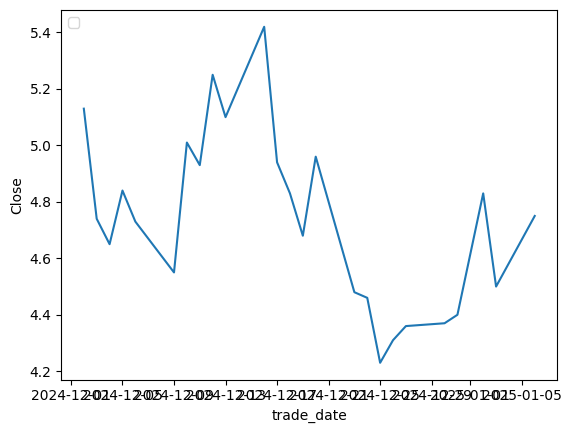

In [140]:
#查看某只股票的区间变动情况--单只股票

df_stock_detail=stock_daily('002127.SZ','20241130','20250106')
# 将日期转换为datetime格式  
# df_stock_detail['trade_date'] = df_stock_detail.to_datetime(df_stock_detail['trade_date'])  
df_stock_detail['trade_date']=pd.to_datetime(df_stock_detail['trade_date'])
# tweets_df['Time'] = pd.to_datetime(tweets_df['Time'])
# 按日期排序  
df_stock_detail = df_stock_detail.sort_values('trade_date')  

# 获取开盘价、最高价、最低价和收盘价，并创建一个新的DataFrame  
OHLC=pd.DataFrame({
    
 'Open': df_stock_detail['open'], 
 'High': df_stock_detail['high'],  
 'Low':df_stock_detail['low'],
 'Close': df_stock_detail['close']  
 })
# 创建K线图  
# OHLC.plot(kind='candle', figsize=(10, 5))  
# mpf.plot(OHLC,type='line')

# 添加图例和标签  
# plt.legend(loc='upper left') 

# 绘制收盘价图形  
fig, ax = plt.subplots()  
ax.plot(df_stock_detail['trade_date'], df_stock_detail['close'])  
ax.set_xlabel('trade_date')  
ax.set_ylabel('Close')  
plt.legend(loc='upper left') 
plt.show()
# df_stock_detail

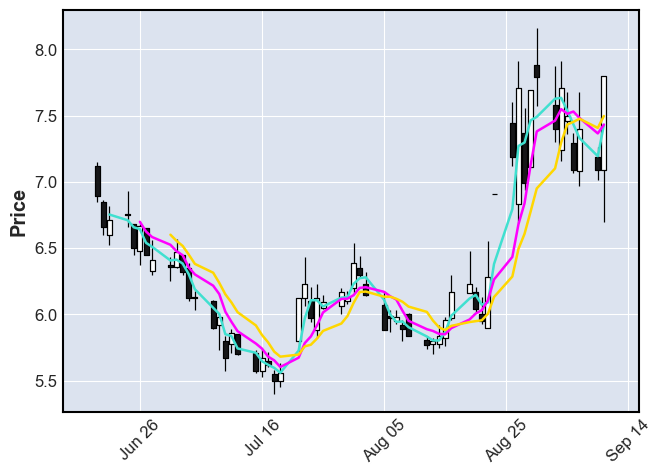

In [23]:
#画K线图- 单只股票--mplfinance 画图
OHLC=pd.DataFrame({
 'tr_date':df_stock_detail['trade_date'], 
 'Open': df_stock_detail['open'], 
 'High': df_stock_detail['high'],  
 'Low':df_stock_detail['low'],
 'Close': df_stock_detail['close']  
 })

# 选取所需的列  
data = OHLC
# 创建K线图  
# fig, ax = plt.subplots()  
# data.plot(kind='line', ax=ax)  
data.tr_date = pd.to_datetime(data.tr_date)
data.index=data.tr_date
mpf.plot(data.tail(60), type='candle',mav=(3,6,9),show_nontrading=True)

# mpf.plot(df_new,type='candle',mav = (3),show_nontrading=True, volume=True)

  
# # 设置坐标轴标签和标题  
# ax.set_xlabel('trade_date')  
# ax.set_ylabel('close')  
# ax.set_title('K-Candle Chart')  
  
# # 显示图像  
# plt.show()


In [52]:
#画K线图- 单只股票--pyechart 画图
OHLC=pd.DataFrame({
 'tr_date':df_stock_detail['trade_date'], 
 'Open': df_stock_detail['open'], 
 'High': df_stock_detail['high'],  
 'Low':df_stock_detail['low'],
 'Close': df_stock_detail['close']  
 })

# 选取所需的列  
data = OHLC




















In [45]:
df_stock_detail

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
358,000004.SZ,2023-01-03,9.67,10.05,9.61,9.94,9.68,0.26,2.6860,21340.62,21096.459
357,000004.SZ,2023-01-04,9.89,10.02,9.81,9.96,9.94,0.02,0.2012,16375.62,16273.674
356,000004.SZ,2023-01-05,9.93,9.98,9.83,9.85,9.96,-0.11,-1.1044,9613.00,9515.336
355,000004.SZ,2023-01-06,9.92,9.92,9.61,9.61,9.85,-0.24,-2.4365,15286.01,14822.851
354,000004.SZ,2023-01-09,9.62,9.75,9.62,9.69,9.61,0.08,0.8325,4642.00,4498.145
...,...,...,...,...,...,...,...,...,...,...,...
4,000004.SZ,2024-06-25,9.76,10.20,9.22,9.44,9.57,-0.13,-1.3584,67959.00,65175.404
3,000004.SZ,2024-06-26,9.25,9.63,9.04,9.62,9.44,0.18,1.9068,61356.00,57192.112
2,000004.SZ,2024-06-27,9.55,10.58,9.40,10.58,9.62,0.96,9.9792,102363.50,105754.117
1,000004.SZ,2024-06-28,10.50,11.64,10.40,11.64,10.58,1.06,10.0189,245271.59,271639.924


In [102]:
df_selected['name']=df_selected.apply(lambda x:get_stock_name(x,df_stocks_age_gt3),axis=1)

C:\Users\admin\AppData\Local\Temp\ipykernel_9404\3604007438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['name']=df_selected.apply(lambda x:get_stock_name(x,df_stocks_age_gt3),axis=1)


In [9]:
df_selected[df_selected['name']=='诺思兰德']

KeyError: 'name'

In [6]:
df_stocks_age_gt3_base['turnover']=df_stocks_age_gt3_base.apply(lambda x:x['ts_code'],axis=1)

In [7]:
#成交额排名前100的股票代码
for ts_code in amount_n('20230421',10):
    print(ts_code)

300750.SZ
002230.SZ
603019.SH
300418.SZ
000977.SZ
601360.SH
688981.SH
000988.SZ
000063.SZ
300059.SZ


In [ ]:
#########以下为基本技术的验证############

In [ ]:
df_selected['name']=df_selected.apply(lambda x:get_stock_name(x,df_stocks_age_gt3),axis=1)

In [64]:
# df_stocks.head(2)
#给行情信息名字
# def get_name(df):
#     df['name']=df[ts]
def get_stock_name(ts_code):
    name=df_stocks.query("ts_code=='{}'".format(ts_code))['name'][0]
    return name
# df_stocks.query("ts_code=='000001.SZ'")

In [93]:
# get_stock_name('000001.SZ')
#获取股票名称
def get_stock_name(df1,df2):
#     name=df.query("ts_code=='{}'".format(df['ts_code']))['name'][0]
    for ts_code in df1['ts_code']:
#         print(ts_code)
        for ts_code2 in df2['ts_code']:
            if  ts_code==ts_code2: 
#                  print(ts_code2,ts_code)   

                 print(df2[df2['ts_code']==ts_code2]['name'])

In [100]:
get_stock_name(df_selected,df_stocks_age_gt3)

2773    诺思兰德
Name: name, dtype: object
5070    三友科技
Name: name, dtype: object
5027    安徽凤凰
Name: name, dtype: object
5119    方大新材
Name: name, dtype: object
5026    创远信科
Name: name, dtype: object
5087    数字人
Name: name, dtype: object
5035    鹿得医疗
Name: name, dtype: object
5086    富士达
Name: name, dtype: object
5147    常辅股份
Name: name, dtype: object
4999    万通液压
Name: name, dtype: object
5024    浩淼科技
Name: name, dtype: object
4996    艾融软件
Name: name, dtype: object
2778    苏轴股份
Name: name, dtype: object
5069    恒拓开源
Name: name, dtype: object
267    中交地产
Name: name, dtype: object
288    甘咨询
Name: name, dtype: object
942    杭氧股份
Name: name, dtype: object
1604    易联众
Name: name, dtype: object
1621    中航电测
Name: name, dtype: object
1637    新国都
Name: name, dtype: object
2268    值得买
Name: name, dtype: object
2276    佳禾智能
Name: name, dtype: object
2978    海南椰岛
Name: name, dtype: object
2983    万通发展
Name: name, dtype: object
2984    陕西建工
Name: name, dtype: object
2995    北方股份
Name: name, dtype: ob

In [97]:
df_tmp=stock_weekly('000001.SZ','20230421','20230516').head(100)

In [98]:
df_tmp

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20230512,12.62,12.94,13.60,12.61,12.91,-0.29,-0.0225,807966857.0,1.060886e+10
1,000001.SZ,20230505,12.91,12.40,13.11,12.19,12.55,0.36,0.0287,324045303.0,4.147127e+09
2,000001.SZ,20230428,12.55,12.48,12.78,11.99,12.50,0.05,0.0040,621018085.0,7.630634e+09
3,000001.SZ,20230421,12.50,12.66,13.20,12.48,12.69,-0.19,-0.0150,558798369.0,7.182669e+09


In [35]:
# 沪深股通十大成交股
# df_tmp=get_source().hsgt_top10(trade_date='20230426', market_type='3')
# df_tmp

In [38]:
condition = (df_tmp['close']-df_tmp['open'])/df_tmp['open']>0.03
#获取满足条件的数据
df_tmp.loc[condition]
#获取满足条件的行索引
# df_tmp.loc[condition].index

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
7,000009.SZ,20220902,14.60,15.33,14.40,15.09,14.43,0.66,4.5738,788862.84,1177303.263
15,000020.SZ,20220902,9.43,9.89,9.41,9.77,9.42,0.35,3.7155,57574.01,55757.641
18,000025.SZ,20220902,18.55,19.95,18.55,19.15,18.40,0.75,4.0761,150920.78,291811.604
26,000034.SZ,20220902,17.42,18.32,17.38,17.97,17.32,0.65,3.7529,154548.58,276420.047
30,000038.SZ,20220902,4.63,4.85,4.63,4.83,4.66,0.17,3.6481,53879.20,25797.709
34,000045.SZ,20220902,8.60,8.91,8.59,8.87,8.62,0.25,2.9002,283834.34,249348.791
37,000049.SZ,20220902,51.01,53.99,50.48,52.72,50.21,2.51,4.9990,135861.83,712678.653
41,000058.SZ,20220902,5.86,6.20,5.84,6.14,5.92,0.22,3.7162,170761.20,103676.101
49,000068.SZ,20220902,3.89,4.13,3.70,4.13,3.75,0.38,10.1333,561303.24,223888.053
51,000070.SZ,20220902,6.51,7.04,6.51,6.92,6.46,0.46,7.1207,274781.13,187171.707


In [9]:
get_source().daily().query("ts_code=='002197.SZ'").head(10)


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
3018,002197.SZ,20230420,11.42,11.61,11.34,11.58,11.41,0.17,1.4899,317725.29,365419.187


In [11]:
#获取股票市场行业列表。
for industry in df_stocks['industry'].unique():
    if industry!=None:
        print(industry)

银行
全国地产
软件服务
环境保护
区域地产
其他商业
运输设备
电气设备
建筑工程
玻璃
家用电器
服饰
农业综合
元器件
水泥
汽车服务
火力发电
医药商业
汽车配件
综合类
新型电力
多元金融
装修装饰
房产服务
商品城
石油加工
铅锌
通信设备
IT设备
旅游景点
港口
机场
石油贸易
空运
生物制药
商贸代理
化学制药
影视音像
工程机械
证券
化纤
供气供热
农药化肥
机床制造
百货
中成药
酒店餐饮
路桥
造纸
医疗保健
食品
黄金
化工原料
专用机械
水运
日用化工
旅游服务
文教休闲
出版业
机械基件
汽车整车
煤炭开采
铁路
染料涂料
白酒
农用机械
林业
水务
水力发电
互联网
广告包装
铝
其他建材
批发业
保险
小金属
铜
普钢
航空
饲料
特种钢
种植业
仓储物流
焦炭加工
纺织
啤酒
超市连锁
钢加工
矿物制品
渔业
软饮料
化工机械
塑料
红黄酒
家居用品
摩托车
石油开采
轻工机械
电器仪表
半导体
乳制品
纺织机械
电器连锁
陶瓷
橡胶
公路
电信运营
公共交通
船舶
园区开发


# 量化股票，预测股票

In [8]:
# from datetime import datetime as dt
# from datetime import date,time
import time
from time import mktime
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta

s='20210101'
e='20210102'
# 字符串转日期
s_date=datetime.strptime(s,'%Y%m%d')
e_date=datetime.strptime(e,'%Y%m%d')
#今天
today=datetime.today().date().strftime('%Y%m%d')
# 上一天
lastday=(datetime.today().date() - timedelta(days=1)).strftime('%Y%m%d')
#上一年
lastyear=(datetime.today().date() - relativedelta(months=12)).strftime('%Y%m%d')
print(s_date) ,print(e_date),print(today),print(lastday),print(lastyear)
# (e_date-s_date).month

2021-01-01 00:00:00
2021-01-02 00:00:00
20230526
20230525
20220526


(None, None, None, None, None)

In [9]:
import time
from time import mktime
from dateutil.relativedelta import relativedelta
from datetime import datetime,timedelta
  
# 获取当前日期  
s='20230526'
# e='20210102'
# today = datetime.date.today()  
# 字符串转日期
today=datetime.strptime(s)
  
# 获取周末日期  
weekend_date = today + datetime.timedelta(days=today.weekday())  
  
# 获取月末日期  
last_day_of_month = datetime.datetime(today.year, today.month, 1).strftime("%d")  
last_day_of_month = int(last_day_of_month)  
last_day_of_month += (30 - last_day_of_month) % 30  
  
print("Today is:", today)  
print("Weekend date:", weekend_date)  
print("Last day of month:", last_day_of_month)

TypeError: strptime() takes exactly 2 arguments (1 given)

In [22]:
import time
from time import mktime
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta

s='20210101'
e='20210102'
# 字符串转日期
s_date=datetime.strptime(s,'%Y%m%d')
e_date=datetime.strptime(e,'%Y%m%d')
lastday=(datetime.today().date() - timedelta(days=1)).strftime('%Y%m%d')

In [24]:
print(s_date,e_date,lastday)

2021-01-01 00:00:00 2021-01-02 00:00:00 20230525
